## Libraries and Utilities

In [420]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import xgboost as xgb
import plotnine
from plotnine import *
import shap
from statistics import mode
import statistics

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_svmlight_files
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score 
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBRFRegressor
from xgboost import plot_importance
from xgboost import plot_tree
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

# visualization modules
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts.basic_charts import pie
import missingno as msno

pd.set_option('display.max_columns', None)

### Read

In [421]:
def read_csv(file):
    df_origin = pd.read_csv(file)

    df = df_origin.replace(['Benign/Likely_benign', 'Pathogenic/Likely_pathogenic'], ['Likely_benign', 'Likely_pathogenic']) 

    df.drop(df[(df['CLNSIG'] != 'Benign') & (df['CLNSIG'] != 'Pathogenic') & (df['CLNSIG'] != 'Likely_benign') & (df['CLNSIG'] != 'Likely_pathogenic')].index, inplace=True)

    df.reset_index(inplace=True)
    df.drop(['index', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

    return df

df = read_csv('./../Data/data_z.csv')

### Consequence

In [422]:
def multi_hot_consequence(df):
    con_split = df['Consequence'].apply(lambda x: x if pd.isna(x) else x.split('&'))
    mlb = MultiLabelBinarizer()
    con_df = pd.DataFrame(mlb.fit_transform(con_split), columns=mlb.classes_)

    return con_df

con_df = multi_hot_consequence(df)

In [423]:
def region_div(con_df):
    def region_gen(x):
        if 'intergenic_variant' in x and x['intergenic_variant'] == 1:
            return 1
        elif 'downstream_gene_variant' in x and x['downstream_gene_variant'] == 1:
            return 2
        elif 'upstream_gene_variant' in x and x['upstream_gene_variant'] == 1:
            return 3
        else:
            return 0

    def region_utr(x):
        if '5_prime_UTR_variant' in x and x['5_prime_UTR_variant'] == 1:
            return 1
        elif '3_prime_UTR_variant' in x and x['3_prime_UTR_variant'] == 1:
            return 2
        else:
            return 0

    def region_in(x):
        if 'intron_variant' in x and x['intron_variant'] == 1:
            return 1
        else:
            return 0

    # ex_con_df = con_df[['synonymous_variant', 'missense_variant', 'inframe_insertion', 'inframe_deletion', 'stop_gained', 'frameshift_variant', 'coding_sequence_variant', 'stop_lost', 'stop_retained_variant', 'start_lost', 'stop_retained_variant']]
    # pca = PCA(n_components=10)
    # principalComponents = pca.fit_transform(con_df)
    # principalDf = pd.DataFrame(data=principalComponents)
    # principalComponents

    def region_ex(x):
        if 'missense_variant' in x and x['missense_variant'] == 1:
            return 2
        elif 'synonymous_variant' in x and x['synonymous_variant'] == 1:
            return 1
        else:
            return 0

    # def region_ex(x):
    #     if x['synonymous_variant'] == 1:
    #         return 1
    #     elif x['missense_variant'] == 1:
    #         return 2
    #     elif x['inframe_insertion'] == 1:
    #         return 3
    #     elif x['inframe_deletion'] == 1:
    #         return 4
    #     elif x['inframe_insertion'] == 1:
    #         return 3
    #     elif x['inframe_insertion'] == 1:
    #         return 3
    #     elif x['inframe_insertion'] == 1:
    #         return 3
    #     elif x['inframe_insertion'] == 1:
    #         return 3
    #     elif x['inframe_insertion'] == 1:
    #         return 3
    #     else:
    #         return 0

    def region_splice(x):
        if 'splice_acceptor_variant' in x and x['splice_acceptor_variant'] == 1:
            return 1
        elif 'splice_donor_variant' in x and x['splice_donor_variant'] == 1:
            return 2
        elif 'splice_region_variant' in x and x['splice_region_variant'] == 1:
            return 3
        else:
            return 0

    con_df['itergenic'] = con_df.apply(lambda x: region_gen(x), axis=1)
    con_df['utr'] = con_df.apply(lambda x: region_utr(x), axis=1)
    con_df['in'] = con_df.apply(lambda x: region_in(x), axis=1)
    # con_df['ex']
    con_df['splice'] = con_df.apply(lambda x: region_splice(x), axis=1)

region_div(con_df)

In [424]:
def merge_df(df, con_df):
    df_copy = df.merge(con_df, left_on=df.index, right_on=con_df.index)
    df_copy.drop('key_0', axis=1, inplace=True)

    return df_copy

df_copy = merge_df(df, con_df)

### M 

#### EXON

In [425]:
def get_EXON(df):
    ex_cols = ['IMPACT',
    #    'SIFT', 'PolyPhen', 'BLOSUM62', 'CADD_phred', 'DANN_rankscore', 'DANN_score', 'Eigen-PC-raw', 'Eigen-raw', 'GERP++_NR', 'LRT_pred', 'MutPred_score', 'MutationTaster_pred', 'PROVEAN_pred', 'REVEL_score', 'VEST3_score', 
       'SiPhy_29way_logOdds', 'SiPhy_29way_logOdds_rankscore', 'phastCons100way_vertebrate', 'phastCons20way_mammalian', 'phyloP20way_mammalian', 'phyloP100way_vertebrate',
       'AF', 
    #    'ada_score', 'rf_score',
       '3_prime_UTR_variant', '5_prime_UTR_variant', 'coding_sequence_variant',
       'intron_variant',
       'splice_acceptor_variant', 'splice_donor_variant',
       'splice', 'utr'
       ]

    df_EXON = df[df['EXON'].notna()]
    
    return df_EXON

df_EXON = get_EXON(df_copy)

In [426]:
def exon_format(df_EXON):
    df_EXON['INTRON'] = df_EXON['INTRON'].apply(lambda x: 1 if pd.notna(x) else 0)

    def get_float(x):
        ans = re.search(r'\((.+?)\)', x)
        return float(ans[1])

    df_EXON['SIFT'] = df_EXON['SIFT'].apply(lambda x: x if pd.isna(x) else get_float(x))

    df_EXON['SIFT_pred'] = df_EXON['SIFT_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    df_EXON['PolyPhen'] = df_EXON['PolyPhen'].apply(lambda x: x if pd.isna(x) else get_float(x))

    def percent(x, D, T):
        count1 = 1 if x.count(D) == 0 else x.count(D)
        count2 = 1 if x.count(T) == 0 else x.count(T)
        sum = 1 if x.count(D) + x.count(T) == 0 else x.count(D) + x.count(T)
        return count1 / sum
        
    df_EXON['FATHMM_pred'] = df_EXON['FATHMM_pred'].apply(lambda x: x if pd.isna(x) else percent(x, 'D', 'T'))

    df_EXON['MutationTaster_pred'] = df_EXON['MutationTaster_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))
                                                                                
    df_EXON['PROVEAN_pred'] = df['PROVEAN_pred'].apply(lambda x: x if pd.isna(x) else percent(x, 'D', 'N'))

    df_EXON['Polyphen2_HDIV_pred'] = df_EXON['Polyphen2_HDIV_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    df_EXON['Polyphen2_HVAR_pred'] = df_EXON['Polyphen2_HVAR_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    def vest3_avr(x):
        ss = x.split('&')
        sum = 0
        index = 0
        for i in ss:
            sum += float(i)
            index += 1
        return sum / index

    df_EXON['VEST3_score'] = df_EXON['VEST3_score'].apply(lambda x: x if pd.isna(x) else vest3_avr(x))

    # df_INTRON['']
    # ada_score
    # df_INTRON['ada_score'] = df_INTRON['ada_score'].fillna(df_INTRON.groupby('Consequence')['ada_score'].transform('mean'))

    # rf_score
    # df_INTRON['rf_score'] = df_INTRON['rf_score'].fillna(df_INTRON.groupby('Consequence')['rf_score'].transform('mean'))

    df_EXON['gnomadWES_AF_POPMAX'] = df_EXON['gnomadWES_AF_POPMAX'].apply(lambda x: 0 if (pd.isna(x)) or (x == '.') else float(x))
    df_EXON['AF'] = df_EXON.apply(lambda x: np.mean([x['MAX_AF'], float(x['gnomadWES_AF_POPMAX'])]), axis=1)

exon_format(df_EXON)
# print(type(format(df_EXON)))

In [427]:
# ex_cols = ['IMPACT',
#        'SIFT', 'PolyPhen', 'BLOSUM62', 'CADD_phred', 'DANN_rankscore', 'DANN_score', 'Eigen-PC-raw', 'Eigen-raw', 'GERP++_NR', 'LRT_pred', 'MutPred_score', 'MutationTaster_pred', 'PROVEAN_pred', 'REVEL_score', 'VEST3_score', 
#        'SiPhy_29way_logOdds', 'SiPhy_29way_logOdds_rankscore', 'phastCons100way_vertebrate', 'phastCons20way_mammalian', 'phyloP20way_mammalian', 'phyloP100way_vertebrate',
#        'AF', 'ada_score', 'rf_score',
#        '3_prime_UTR_variant', '5_prime_UTR_variant', 'coding_sequence_variant',
#        'intron_variant',
#        'splice_acceptor_variant', 'splice_donor_variant',
#        'splice', 'utr'
#        ]

# df_EXON = df_copy[df['EXON'].notna()]

# df_EXON['INTRON'] = df_EXON['INTRON'].apply(lambda x: 1 if pd.notna(x) else 0)

# def get_float(x):
#     ans = re.search(r'\((.+?)\)', x)
#     return float(ans[1])

# df_EXON['SIFT'] = df_EXON['SIFT'].apply(lambda x: x if pd.isna(x) else get_float(x))

# df_EXON['SIFT_pred'] = df_EXON['SIFT_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

# df_EXON['PolyPhen'] = df_EXON['PolyPhen'].apply(lambda x: x if pd.isna(x) else get_float(x))

# def percent(x, D, T):
#     count1 = 1 if x.count(D) == 0 else x.count(D)
#     count2 = 1 if x.count(T) == 0 else x.count(T)
#     sum = 1 if x.count(D) + x.count(T) == 0 else x.count(D) + x.count(T)
#     return count1 / sum
    
# df_EXON['FATHMM_pred'] = df_EXON['FATHMM_pred'].apply(lambda x: x if pd.isna(x) else percent(x, 'D', 'T'))

# df_EXON['MutationTaster_pred'] = df_EXON['MutationTaster_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

# df_EXON['PROVEAN_pred'] = df['PROVEAN_pred'].apply(lambda x: x if pd.isna(x) else percent(x, 'D', 'N'))

# df_EXON['Polyphen2_HDIV_pred'] = df_EXON['Polyphen2_HDIV_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

# df_EXON['Polyphen2_HVAR_pred'] = df_EXON['Polyphen2_HVAR_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

# def vest3_avr(x):
#     ss = x.split('&')
#     sum = 0
#     index = 0
#     for i in ss:
#         sum += float(i)
#         index += 1
#     return sum / index

# df_EXON['VEST3_score'] = df_EXON['VEST3_score'].apply(lambda x: x if pd.isna(x) else vest3_avr(x))

# # df_INTRON['']
# # ada_score
# # df_INTRON['ada_score'] = df_INTRON['ada_score'].fillna(df_INTRON.groupby('Consequence')['ada_score'].transform('mean'))

# # rf_score
# # df_INTRON['rf_score'] = df_INTRON['rf_score'].fillna(df_INTRON.groupby('Consequence')['rf_score'].transform('mean'))

# df_EXON['gnomadWES_AF_POPMAX'] = df_EXON['gnomadWES_AF_POPMAX'].apply(lambda x: 0 if (pd.isna(x)) or (x == '.') else float(x))
# df_EXON['AF'] = df_EXON.apply(lambda x: np.mean([x['MAX_AF'], float(x['gnomadWES_AF_POPMAX'])]), axis=1)
# df_EXON['AF'].fillna(0)


# label_cols = ['IMPACT', 'SIFT_pred', 'LRT_pred', 'M-CAP_pred', 'MetaLR_pred', 'MetaSVM_pred', 'MutationAssessor_pred', 'MutationTaster_pred', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred']

# na_cols = ['IMPACT', 'INTRON',
#        'SIFT', 'SIFT_pred', 'PolyPhen', 'BLOSUM62', 'CADD_phred', 'CADD_raw', 'CADD_raw_rankscore', 'DANN_rankscore', 'DANN_score', 'Eigen-PC-raw', 'Eigen-raw', 'FATHMM_pred', 'GERP++_NR', 'GERP++_RS', 'LRT_pred', 'M-CAP_pred', 'MetaLR_pred', 'MetaSVM_pred', 'MutPred_rankscore', 'MutPred_score', 'MutationAssessor_pred', 'MutationTaster_pred', 'PROVEAN_pred', 'REVEL_rankscore', 'REVEL_score', 'VEST3_rankscore', 'VEST3_score', 
#        'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred', 'SiPhy_29way_logOdds', 'phastCons100way_vertebrate', 'phastCons20way_mammalian', 'phyloP20way_mammalian', 'phyloP100way_vertebrate'
#        ]
    
# df_EXON['AF'].fillna(0, inplace=True)
# for item in na_cols:
#     if df_EXON[item].dtype == float:
#         df_EXON[item] = df_EXON[item].fillna(df_EXON.groupby('Consequence')[item].transform('mean'))
#     else:
#         df_EXON[item] = df_EXON[item].fillna(df_EXON.groupby('Consequence')[item].transform(mode))

# for key in associate_dict.keys():
#     # df_EXON['frameshift_variant'] = df_EXON[['frameshift_variant', 'start_lost', 'stop_lost', 'stop_gained']].sum(axis=1)
#     df_EXON[key] = df_EXON[[key] + associate_dict[key]].sum(axis=1)

#     for col in na_cols:
#         if df_EXON[col].dtype != object:
#             mean = df_EXON[df_EXON[key] >= 1][col].mean()
#             df_EXON[col] = df_EXON.apply(lambda x: mean if (x[key] >= 1) & (pd.isna(x[col])) else x[col], axis=1)
#         else:
#             mode = df_EXON[df_EXON[key] >= 1][col].mode()
#             # print(mode[0])
#             df_EXON[col] = df_EXON.apply(lambda x: mode[0] if (x[key] >= 1) & (pd.isna(x[col])) else x[col], axis=1)

#     df_EXON[key] = df_EXON[key].apply(lambda x: 1 if x >= 1 else 0)

In [428]:
def ex_fillna(df_EXON):
    df_EXON['AF'].fillna(0, inplace=True)

    na_cols = ['IMPACT', 'INTRON',
       'SIFT', 'SIFT_pred', 'PolyPhen', 'BLOSUM62', 'CADD_phred', 'CADD_raw', 'CADD_raw_rankscore', 'DANN_rankscore', 'DANN_score', 'Eigen-PC-raw', 'Eigen-raw', 'FATHMM_pred', 'GERP++_NR', 'GERP++_RS', 'LRT_pred', 'M-CAP_pred', 'MetaLR_pred', 'MetaSVM_pred', 'MutPred_rankscore', 'MutPred_score', 'MutationAssessor_pred', 'MutationTaster_pred', 'PROVEAN_pred', 'REVEL_rankscore', 'REVEL_score', 'VEST3_rankscore', 'VEST3_score', 
       'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred', 'SiPhy_29way_logOdds', 'phastCons100way_vertebrate', 'phastCons20way_mammalian', 'phyloP20way_mammalian', 'phyloP100way_vertebrate'
       ]
    
    for item in na_cols:
        if df_EXON[item].dtype == float:
            df_EXON[item] = df_EXON[item].fillna(df_EXON.groupby('Consequence')[item].transform('mean'))
        else:
            df_EXON[item] = df_EXON[item].fillna(df_EXON.groupby('Consequence')[item].transform(mode))

ex_fillna(df_EXON)


In [429]:
def lb_coding(df):
    label_cols = ['IMPACT', 'SIFT_pred', 'LRT_pred', 'M-CAP_pred', 'MetaLR_pred', 'MetaSVM_pred', 'MutationAssessor_pred', 'MutationTaster_pred', 'Polyphen2_HDIV_pred', 'Polyphen2_HVAR_pred']

    df_res = df.copy()
    for col in label_cols:
        df_res[col] = LabelEncoder().fit(df[col].unique()).transform(df[col])
    
    if 'CLNSIG' in df.columns:
        # CLNSIG
        df_res['CLNSIG'] = LabelEncoder().fit(df['CLNSIG'].unique()).transform(df['CLNSIG'])
        df_res['CLNSIG2'] = df_res['CLNSIG'].apply(lambda x: 1 if x > 1 else 0)

    return df_res

df_EXON = lb_coding(df_EXON)

In [430]:
ex_cols = [# 'IMPACT',
       # 'SIFT', 'PolyPhen', 'BLOSUM62', 'CADD_phred', 'DANN_rankscore', 'DANN_score', 'Eigen-PC-raw', 'Eigen-raw', 'GERP++_NR', 'LRT_pred', 'MutPred_score', 'MutationTaster_pred', 'PROVEAN_pred', 'REVEL_score', 'VEST3_score', 
       # 'SiPhy_29way_logOdds', 'SiPhy_29way_logOdds_rankscore', 'phastCons100way_vertebrate', 'phastCons20way_mammalian', 'phyloP20way_mammalian', 'phyloP100way_vertebrate',
       'AF', 
       'ada_score', 'rf_score',
       # '3_prime_UTR_variant', '5_prime_UTR_variant', 'coding_sequence_variant',
       'intron_variant',
       'splice_acceptor_variant', 'splice_donor_variant',
       'splice', 'utr'
       ]
       
inputs_ex = df_EXON[ex_cols]
target_ex = df_EXON['CLNSIG2']

ros =  RandomOverSampler(random_state=0)

X_ex_train, X_ex_test, y_ex_train, y_ex_test = train_test_split(inputs_ex, target_ex, test_size = 0.25, shuffle = True)

X_ex_train, y_ex_train = ros.fit_resample(X_ex_train, y_ex_train)

bst_ex = XGBRFRegressor()

bst_ex.fit(X_ex_train, y_ex_train)

res_ex = pd.DataFrame(y_ex_test)
res_ex['pred'] = bst_ex.predict(X_ex_test)


<AxesSubplot:xlabel='pred', ylabel='Density'>

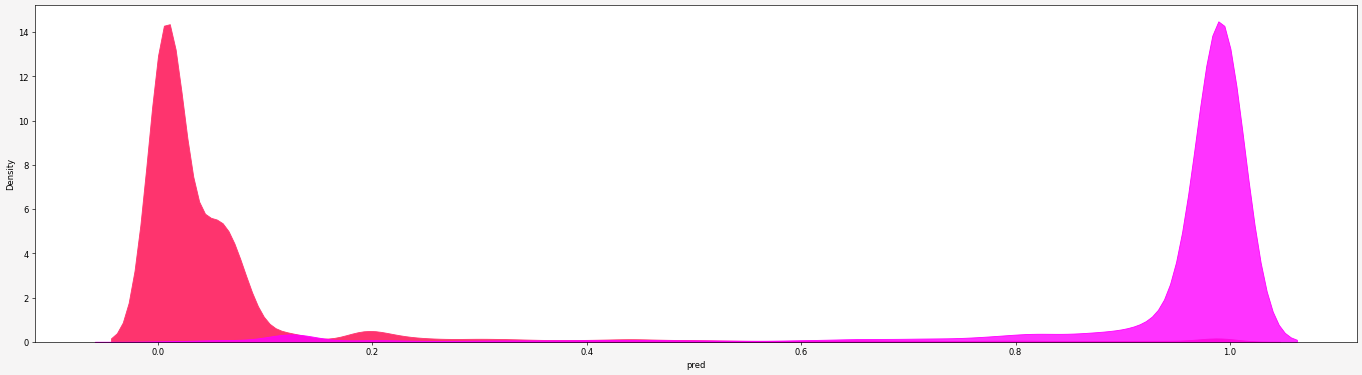

In [431]:
fig = plt.figure(figsize=(72, 52), dpi=60)

gs = fig.add_gridspec(20, 20)
# gs.update(wspace=1, hspace=0.05)
ax1 = fig.add_subplot(gs[1:4, 0:8])

fig.patch.set_facecolor('#f6f5f5')

sns.kdeplot(data=res_ex[res_ex['CLNSIG2'] == 0], x='pred', ax=ax1, shade=True, color='#fe346e', alpha=1)
sns.kdeplot(data=res_ex[res_ex['CLNSIG2'] == 1], x='pred', ax=ax1, shade=True, color='#FF00FF', alpha=0.8)

In [432]:
res_ex['pred_class'] = res_ex['pred'].apply(lambda x: 1 if x > 0.5 else 0)
print(confusion_matrix(res_ex['CLNSIG2'], res_ex['pred_class']))
print(len(res_ex[(res_ex['CLNSIG2'] == 1) & (res_ex['pred_class'] == 1)]) / len(res_ex[res_ex['CLNSIG2'] == 1]))
print(classification_report(res_ex['CLNSIG2'], res_ex['pred_class']))

[[41748  1271]
 [ 1307 26920]]
0.953696815106104
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     43019
           1       0.95      0.95      0.95     28227

    accuracy                           0.96     71246
   macro avg       0.96      0.96      0.96     71246
weighted avg       0.96      0.96      0.96     71246



[7.6809824e-01 3.9033585e-03 7.9190527e-04 9.6352684e-05 1.0985119e-02
 2.3417023e-04 3.0000441e-04 4.1415638e-04 7.7439258e-03 1.1561158e-04
 7.4238749e-05 8.3677005e-03 4.3228837e-03 4.7002302e-04 1.3755803e-01
 2.7469851e-02 1.1934426e-04 1.9368832e-04 8.1212645e-05 1.0226800e-04
 1.0147315e-04 1.4413931e-04 2.0225893e-03 3.1339694e-03 3.5704488e-06
 4.9678333e-06 7.4265336e-07 4.4351039e-04 2.2702886e-02]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

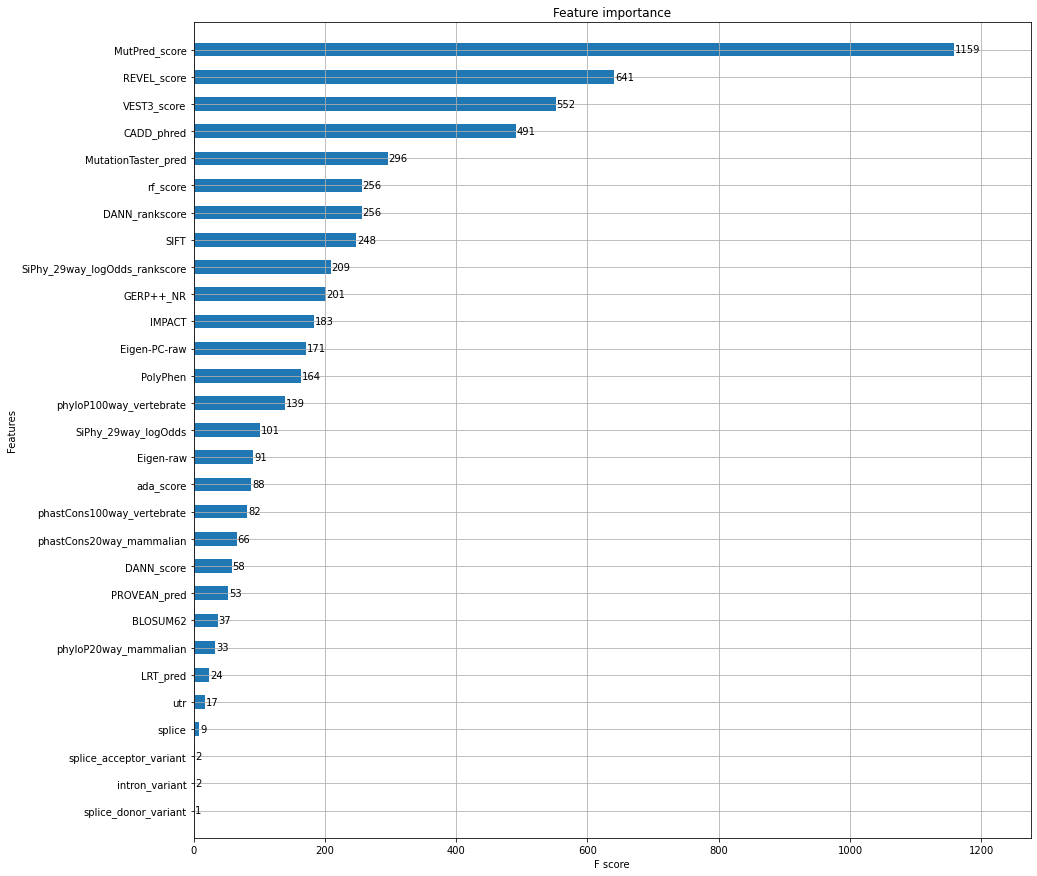

In [433]:
print(bst_ex.feature_importances_)
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(bst_ex, height=0.5, ax=ax)

### Validation datas(BRCA1 variants) 

In [434]:
df_vali = pd.read_csv('../Data/验证/xxx2.csv')
df_brca1 = pd.read_csv('../Data/验证/BRCA1.csv')


In [435]:
df_vali = df_vali.merge(df_brca1, left_on=['POS', 'REF', 'ALT'], right_on=['pos.hg19', 'ref', 'alt'])

In [436]:
con_df_vali = multi_hot_consequence(df_vali)

In [437]:
region_div(con_df_vali)

In [438]:
con_df_vali = multi_hot_consequence(df_vali)

region_div(con_df_vali)

df_vali_copy = merge_df(df_vali, con_df_vali)

In [439]:
df_vali_EXON = df_vali_copy[df_vali_copy['EXON'].notna()]

In [440]:
exon_format(df_vali_EXON)

ex_fillna(df_vali_EXON)

df_vali_EXON = lb_coding(df_vali_EXON)

In [441]:
df_vali_EXON['ClinVar_CLNSIG'].value_counts()

not_provided                                    1743
Uncertain_significance                           388
Likely_benign                                    141
Pathogenic                                       123
Conflicting_interpretations_of_pathogenicity      74
Pathogenic/Likely_pathogenic                      26
Likely_pathogenic                                 24
Benign                                            18
Benign/Likely_benign                               3
Name: ClinVar_CLNSIG, dtype: int64

In [442]:
res_vali_ex = pd.DataFrame(df_vali_EXON['function.score'])
res_vali_ex['functional.class'] = df_vali_EXON['functional.class']
res_vali_ex['ClinVar_CLNSIG'] = df_vali_EXON['ClinVar_CLNSIG']
# res_vali_ex['pred'] = bst_ex.predict(X_ex_test)

In [443]:
res_vali_ex['pred'] = bst_ex.predict(df_vali_EXON[ex_cols])

In [444]:
res_vali_ex

,function.score,functional.class,ClinVar_CLNSIG,pred
9,-0.207552,FUNC,not_provided,0.009367
10,0.003993,FUNC,not_provided,0.009367
11,-0.278636,FUNC,not_provided,0.009367
12,-0.530383,FUNC,not_provided,0.009367
13,-0.148420,FUNC,not_provided,0.009367
...,...,...,...,...
3467,-0.118783,FUNC,Conflicting_interpretations_of_pathogenicity,0.007913
3468,0.163587,FUNC,not_provided,0.700992
3469,0.116923,FUNC,not_provided,0.700992
3470,-0.449638,FUNC,not_provided,0.707265


In [449]:
# pd.set_option('display.max_rows', None)
# print(res_vali_ex[(res_vali_ex['pred'] > 0.5) & (res_vali_ex['functional.class'] == 'FUNC')].drop('function.score', axis=1))
# pd.set_option('display.max_rows', 10)

     functional.class                                ClinVar_CLNSIG      pred
75               FUNC                                  not_provided  0.707507
76               FUNC                                  not_provided  0.929887
77               FUNC                                  not_provided  0.894842
80               FUNC                                  not_provided  0.702932
81               FUNC                                  not_provided  0.702932
83               FUNC                                  not_provided  0.572088
85               FUNC                                  not_provided  0.628031
87               FUNC                                  not_provided  0.651514
90               FUNC                        Uncertain_significance  0.580591
91               FUNC                                  not_provided  0.580591
92               FUNC                                  not_provided  0.641760
93               FUNC                                  not_provi